# Cox model analysis for HEGP Data

The notebook is divided in the following sections:
    - Loading the Data and Choosing the pertinent one:
        ° Using a python script the data is extracted from the different txt or csv file: 3 DataFrame generated
        - Cleaning the data
            ° Deleting the data which has only one NaN represented in the SITC_HEGP_Data
            ° Deleting the categorical data which has only one level represented in the SITC_HEGP_Data
        -Choosing the Data
            ° Deleting the data not currently used
        - Converting the objects to numeric:
            ° Replacing the NaN by the median of the data
    - Dividing in train and test set
        ° Keeping the original DataFrame, 2 different DataFrame generated
    -Wald Test
        -Only the immunoscore:  UNIVARIATE
            - C-index in prediction on the test set
        -MULTIVARIATE 
            ° Reloading Data
            ° Binarization of the categorical Data
            ° Standardization of the numerical Data
            ° Dividing in train and test set
            ° C-index in prédiction
        

http://www.sthda.com/english/wiki/cox-proportional-hazards-model

The Cox proportional-hazards model (Cox, 1972) is essentially a regression model commonly used statistical in medical research for investigating the association between the survival time of patients and one or more predictor variables.

In the previous chapter (survival analysis basics), we described the basic concepts of survival analyses and methods for analyzing and summarizing survival data, including:

    the definition of hazard and survival functions,
    the construction of Kaplan-Meier survival curves for different patient groups
    the logrank test for comparing two or more survival curves

The above mentioned methods - Kaplan-Meier curves and logrank tests - are examples of univariate analysis. They describe the survival according to one factor under investigation, but ignore the impact of any others.

Additionally, Kaplan-Meier curves and logrank tests are useful only when the predictor variable is categorical (e.g.: treatment A vs treatment B; males vs females). They don’t work easily for quantitative predictors such as gene expression, weight, or age.

An alternative method is the Cox proportional hazards regression analysis, which works for both quantitative predictor variables and for categorical variables. Furthermore, the Cox regression model extends survival analysis methods to assess simultaneously the effect of several risk factors on survival time.


In [33]:
%reset -f
%matplotlib inline
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import os
import rpy2.robjects as ro
import pylab as pl
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from load_Data_forCox import load_Data_forCox
from sklearn.preprocessing import StandardScaler
from QNEM.inference import QNEM
from tick.preprocessing.features_binarizer import FeaturesBinarizer

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


ModuleNotFoundError: No module named 'tick'

## Loading data

In [5]:
X, Y, delta = load_Data_forCox()


C:\Users\HEGP\Documents\Maud\Dropbox\Stage_Moi\Mimic_Dropbox\Notebook\load_Data_forCox.py:52: FutureWarning: 'OfficialID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df_final=df_final.merge(data_ID,on='OfficialID')
C:\Users\HEGP\Documents\Maud\Dropbox\Stage_Moi\Mimic_Dropbox\Notebook\load_Data_forCox.py:79: FutureWarning: 'OfficialID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df_final=df_final.merge(df_CD3_CT,on='OfficialID')
C:\Users\HEGP\Documents\Maud\Dropbox\Stage_Moi\Mimic_Dropbox\Notebook\load_Data_forCox.py:117: FutureWarning: 'OfficialID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  data_TTR=data_TTR.merge(data_ID,on='OfficialID')


StopIteration: 

StopIteration: 

In [9]:
X.columns

Index(['gender', 'age', 't_stage_mod_6is4_7is1', 'n_stage', 'plnode',
       'UICC_TNM', 'postop_chemo', 'nlnode', 'plnode', 'sidedness',
       'ascending', 'transverse', 'descending', 'sigmoid', 'differentiation',
       'mucinous_colloide', 'occlusion', 'perforation', 'venous_emboli',
       'lymphatic_invasion', 'perineural_invasion', 'msi_gen', 'p53_status',
       'kras_status', 'apc_status', 'braf_status', 'pi3k_status',
       'CD3_Tumor_Density', 'CD3_IM_Density', 'CD8_Tumor_Density',
       'CD8_IM_Density', 'Immunoscore'],
      dtype='object')

### Cleaning Data

In [7]:
# only NaN values
X =X.drop(['postop_biotherapy', "preop_chemo",
                "colon", "cecum", "splenflex", "hepflex",
                "immuno_tx", "msi_ihc", "lynch_syndrome",
                "fap", "ibs", "tumor_budding", "cimp", "MSI_NBP",
                "surg_pt_type", "m_stage"], axis=1)

In [8]:
# One column is redundant
## get column names and rename one of the plnode column plnodedrop
X.dtypes


gender                    object
age                      float64
t_stage_mod_6is4_7is1     object
n_stage                   object
plnode                   float64
UICC_TNM                  object
postop_chemo              object
nlnode                   float64
plnode                   float64
sidedness                 object
ascending                 object
transverse                object
descending                object
sigmoid                   object
differentiation           object
mucinous_colloide         object
occlusion                 object
perforation               object
venous_emboli             object
lymphatic_invasion        object
perineural_invasion       object
msi_gen                   object
p53_status                object
kras_status               object
apc_status                object
braf_status               object
pi3k_status               object
CD3_Tumor_Density         object
CD3_IM_Density            object
CD8_Tumor_Density         object
CD8_IM_Den

In [11]:
column_names =['gender', 'age', 't_stage_mod_6is4_7is1', 'n_stage', 'plnodedrop',
       'UICC_TNM', 'postop_chemo', 'nlnode', 'plnode', 'sidedness',
       'ascending', 'transverse', 'descending', 'sigmoid', 'differentiation',
       'mucinous_colloide', 'occlusion', 'perforation', 'venous_emboli',
       'lymphatic_invasion', 'perineural_invasion', 'msi_gen', 'p53_status',
       'kras_status', 'apc_status', 'braf_status', 'pi3k_status',
       'CD3_Tumor_Density', 'CD3_IM_Density', 'CD8_Tumor_Density',
       'CD8_IM_Density', 'Immunoscore']
X.columns = column_names
X = X.drop(["plnodedrop"], axis=1)

In [12]:
# Droping the column not analysed
X= X.drop(['CD3_Tumor_Density', "CD3_IM_Density",
                 "CD8_Tumor_Density", "CD8_IM_Density"], axis=1)

In [13]:
# Converting the objects to numeric
X = X.convert_objects(convert_numeric=True)
# Replacing the NaN by the median of the data
X.fillna(X.median(), inplace=True)

C:\Users\HEGP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [14]:
X.columns

Index(['gender', 'age', 't_stage_mod_6is4_7is1', 'n_stage', 'UICC_TNM',
       'postop_chemo', 'nlnode', 'plnode', 'sidedness', 'ascending',
       'transverse', 'descending', 'sigmoid', 'differentiation',
       'mucinous_colloide', 'occlusion', 'perforation', 'venous_emboli',
       'lymphatic_invasion', 'perineural_invasion', 'msi_gen', 'p53_status',
       'kras_status', 'apc_status', 'braf_status', 'pi3k_status',
       'Immunoscore'],
      dtype='object')

## Dividing in train and test set

In [15]:
X.index = np.arange(X.shape[0])
delta.index = np.arange(X.shape[0])
Y.index = np.arange(X.shape[0])

## Split data into training and test sets ##
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X.loc[test_index]
    delta_test = delta.loc[test_index]
    Y_test = Y.loc[test_index]

    X = X.loc[train_index]
    Y = Y.loc[train_index]
    delta = delta.loc[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Wald Test
The Wald test (also called the Wald Chi-Squared Test) is a way to find out if explanatory variables in a model are significant. “Significant” means that they add something to the model; variables that add nothing can be deleted without affecting the model in any meaningful way. The test can be used for a multitude of different models including those with binary variables or continuous variables.


The null hypothesis for the test is: some parameter = some value. For example, you might be studying if weight is affected by eating junk food twice a week. “Weight” would be your parameter. The value could be zero (indicating that you don’t think weight is affected by eating junk food). If the null hypothesis is rejected, it suggests that the variables in question can be removed without much harm to the model fit.

    If the Wald test shows that the parameters for certain explanatory variables are zero, you can remove the variables from the model.
    If the test shows the parameters are not zero, you should include the variables in the model.

The Wald test is usually talked about in terms of chi-squared, because the sampling distribution (as n approaches infinity) is usually known. This variant of the test is sometimes called the Wald Chi-Squared Test to differentiate it from the Wald Log-Linear Chi-Square Test, which is a non-parametric variant based on the log odds ratios.

# Check Wald Test  

### Univariate
Immunoscore only

In [16]:
df=X[['Immunoscore']].astype(np.int8)
df["Y"] = Y
df["delta"] = delta
df.dtypes

Immunoscore       int8
Y              float64
delta            int64
dtype: object

In [17]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, duration_col='Y', event_col='delta')
cph.print_summary()

n=207, number of events=42

               coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Immunoscore -0.9072     0.4036    0.2599 -3.4913 0.0005     -1.4165     -0.3979  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.646


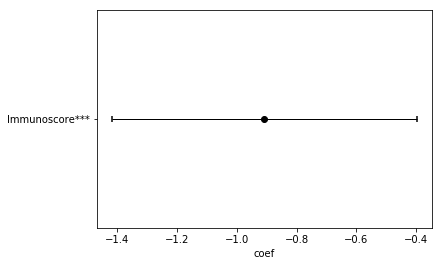

In [21]:
cph.plot()

#### C-index prediction

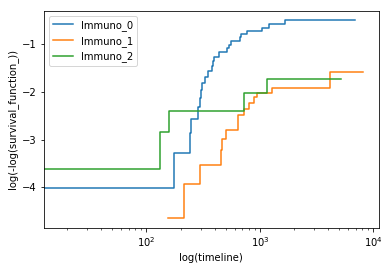

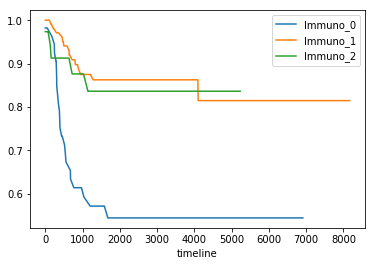

In [28]:
from matplotlib import pyplot as plt
from lifelines import KaplanMeierFitter

Immuno_0 = df.loc[df['Immunoscore'] == 0]
Immuno_1 =df.loc[df['Immunoscore'] == 1]
Immuno_2 =df.loc[df['Immunoscore'] == 2]

kmf0 = KaplanMeierFitter()
kmf0.fit(Immuno_0['Y'], event_observed=Immuno_0['delta'])

kmf1 = KaplanMeierFitter()
kmf1.fit(Immuno_1['Y'], event_observed=Immuno_1['delta'])

kmf2 = KaplanMeierFitter()
kmf2.fit(Immuno_2['Y'], event_observed=Immuno_2['delta'])

fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)
kmf2.plot_loglogs(ax=axes)
axes.legend(['Immuno_0', 'Immuno_1','Immuno_2'])

plt.show()

fig, axes = plt.subplots()
kmf0.survival_function_.plot(ax=axes)
kmf1.survival_function_.plot(ax=axes)
kmf2.survival_function_.plot(ax=axes)
axes.legend(['Immuno_0', 'Immuno_1','Immuno_2'])

plt.show()


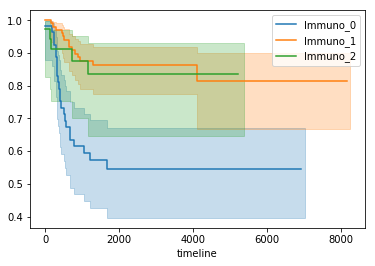

In [30]:
# interval de confiance
fig, axes = plt.subplots()
kmf0.plot(ax=axes)
kmf1.plot(ax=axes)
kmf2.plot(ax=axes)
axes.legend(['Immuno_0', 'Immuno_1','Immuno_2'])

plt.show()

In [18]:
X_test_immunoscore = X_test[['Immunoscore']].astype(np.int8)
hat_beta = cph.summary.coef
marker_test = X_test_immunoscore.dot(hat_beta)
c_index = concordance_index(np.ravel(Y_test), marker_test, np.ravel(delta_test))
c_index = max(c_index, 1 - c_index)
print("C-index on test set: %.2f" % c_index)

C-index on test set: 0.59


### Multivariate
Reload data

In [19]:
X.index = np.arange(X.shape[0])
delta.index = np.arange(X.shape[0])
Y.index = np.arange(X.shape[0])

#### Standardisation
Permet d'avoir les vrai coefficients, annule la moyenne empirique et permet d'obtenir une variance unité
Necessaire pour le train set

In [20]:
X_cont = X[["age", "nlnode", "plnode"]]
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X_cont), columns=X_cont.columns)
X.drop(["age", "nlnode", "plnode"], axis=1, inplace=True)

#### Binarization
Pour les données catégorielles ils existent un lien linéaire entre les colonnes, donc une matrice de 1x3 a un rang 2 et non 3.
Elle n'est donc pas inversible, elle est mal condionnée or cela est nécessaire dans les modèles de survie car il faut que le modèle converge, il faut donc imposer une contrainte linéaire.
 Une des solutions est de sommer les effets à 0.
 Une autre est de mettre le premier coefficient à 0 et de créer une sparse matrix.
    

In [ ]:
binarizer = FeaturesBinarizer(remove_first=True) # retire la première colonne
X_bin = binarizer.fit_transform(X)
X_bin = X_bin.todense() #sparse matrix
blocks_start = binarizer.blocks_start # position des premières colonnes de chaque variables
blocks_length = binarizer.blocks_length #nombre de niveau
# Manque les en-tête, donc les données ne sont pas identifiables ce qui rend toute analyse impossible
columns_names = []
for i in range(X.shape[1]):
    for j in range(1, blocks_length[i]):
        columns_names += [X.columns[i] + "=" + str(j)]
        
X_bin = pd.DataFrame(X_bin, columns=columns_names)
X = pd.concat([X_cont,X_bin], axis=1)

#### Dividing in train and test set

In [ ]:
## Split data into training and test sets ##
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X.loc[test_index]
    delta_test = delta.loc[test_index]
    Y_test = Y.loc[test_index]

    X = X.loc[train_index]
    Y = Y.loc[train_index]
    delta = delta.loc[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

#### C-index prediction

In [ ]:
df = X.copy()
df["Y"] = Y
df["delta"] = delta

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, duration_col='Y', event_col='delta')
cph.print_summary()

In [ ]:
hat_beta = cph.summary.coef
marker_test = X_test.dot(hat_beta)
c_index = concordance_index(np.ravel(Y_test), marker_test, np.ravel(delta_test))
c_index = max(c_index, 1 - c_index)
print("C-index on test set: %.2f" % c_index)